### Transformer Based Architecture

Below is the model definition for a Transformer Network with a Convolutional Patch Embedding layer. Your task is to optimize the network architecture below to improve the model performance. The minimum criteria for success is %80 validation accuracy. Share your training setup including your architecture and any other modifications you have made after the assignment deadline in the Moodle forum. Three students who have the highest accuracy among you will get 2 extra points.

You are free to use other components like MaxPool2d, Dropout, and ReLU from torch.nn library. Please remember the architectural innovations and regularization methods mentioned in the class and try to emulate them here. You can also change augmentation, learning rate schedulers, and optimization methods as you like. Don't use predefined models right away but you can reimplement them yourselves.

You will find an implementation from our class for Attention Head and Attention Blocks. Feel free to improve this implementation and integrate other components. Keep in mind that Cifar10 is not a very large dataset so optimizing transformers may prove to be more difficult which is generally not true for larger datasets. Try to restrict the number of parameters that you have in order to get a good generalization performance.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

In [ ]:
# Data augmentation for training images
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),          # Randomly crop a 32x32 region from the image with padding of 4 pixels
    transforms.RandomHorizontalFlip(0.5),         # Horizontally flip the image with a probability of 50%
    transforms.ColorJitter(0.2, 0.2, 0.2),        # Apply random changes to brightness, contrast, and saturation (factor = 0.2)
    transforms.ToTensor(),                        # Convert the image to a PyTorch tensor and scale pixel values to [0, 1]
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)) # Normalize the tensor with CIFAR-10 dataset mean and standard deviation
])

# Data transformation for testing images
test_transform = transforms.Compose([
    transforms.ToTensor(),                        # Convert the image to a PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)) # Normalize the tensor with CIFAR-10 dataset mean and standard deviation
])

# Download and load the CIFAR-10 training dataset
cifar10 = torchvision.datasets.CIFAR10(
    root='./data',                               # Path to download the dataset
    train=True,                                  # Indicate that this is the training set
    download=True,                               # Download the dataset if it's not already available
    transform=transform                          # Apply the specified data augmentation transformations
)

# Download and load the CIFAR-10 testing dataset
cifar10_test = torchvision.datasets.CIFAR10(
    root='./data',                               # Path to download the dataset
    train=False,                                 # Indicate that this is the testing set
    download=True,                               # Download the dataset if it's not already available
    transform=test_transform                     # Apply the specified transformations for testing
)

# Set the batch size for processing data
batch_size = 64

# DataLoader for training images
train_loader = DataLoader(
    cifar10,                                     # Training dataset
    batch_size=batch_size,                       # Number of images in each batch
    shuffle=True,                                # Shuffle the dataset to ensure random sampling
    num_workers=2                                # Number of worker threads for data loading
)

# DataLoader for testing images
test_loader = DataLoader(
    cifar10_test,                                # Testing dataset
    batch_size=batch_size,                       # Number of images in each batch
    shuffle=False,                               # Do not shuffle the testing dataset
    num_workers=2                                # Number of worker threads for data loading
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define Attention Head
class Head(nn.Module):
    def __init__(self, head_size, embed_dim=None):
        super().__init__()
        self.head_size = head_size
        embed_dim = head_size if embed_dim is None else embed_dim
        self.key = nn.Linear(embed_dim, head_size, bias=False)
        self.query = nn.Linear(embed_dim, head_size, bias=False)
        self.value = nn.Linear(embed_dim, head_size, bias=False)

    def forward(self, x):
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        weight = q @ k.transpose(-2, -1) * self.head_size**-0.5
        weight = F.softmax(weight, dim=-1)
        return weight @ v

# Multi-head Attention
class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        head_size = embed_dim // num_heads
        self.heads = nn.ModuleList([Head(head_size, embed_dim) for _ in range(num_heads)])
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        output = torch.cat([h(x) for h in self.heads], dim=2)
        return self.proj(output)

# FeedForward for Transformer
class FeedForward(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Linear(4 * embed_dim, embed_dim)
        )

    def forward(self, x):
        return self.net(x)

# Transformer Block
class Block(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.sa = MultiheadAttention(embed_dim, num_heads)
        self.ffwd = FeedForward(embed_dim)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.sa(self.ln1(x)))
        x = x + self.dropout(self.ffwd(self.ln2(x)))
        return x

# Flatten and Position Embedding
class Flatten_Spatial(nn.Module):
    def __init__(self, grid_size, embed_dim):
        super().__init__()
        self.grid_size = grid_size
        self.embed_dim = embed_dim
        self.pos_embed = self.build_2d_sincos_position_embedding(self.grid_size, self.embed_dim)

    def build_2d_sincos_position_embedding(self, grid_size, embed_dim, temperature=10000.):
        h, w = grid_size
        grid_w, grid_h = torch.meshgrid(torch.arange(w), torch.arange(h))
        pos_dim = embed_dim // 4
        omega = 1. / (temperature ** (torch.arange(pos_dim) / pos_dim))
        out_w = torch.einsum('m,d->md', [grid_w.flatten(), omega])
        out_h = torch.einsum('m,d->md', [grid_h.flatten(), omega])
        pos_embed = torch.cat([torch.sin(out_w), torch.cos(out_w), torch.sin(out_h), torch.cos(out_h)], dim=1)
        return nn.Parameter(pos_embed[None, :, :], requires_grad=False)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).reshape(B, H * W, C)
        return x + self.pos_embed

In [ ]:
# Define a Transformer-based model for CIFAR-10 classification
class TransformerModel(nn.Module):
    def __init__(self):
        super().__init__()  # Initialize the parent class (nn.Module)

        # Define the sequential architecture of the model
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),   # Convolutional layer: 3 input channels (RGB), 32 filters
            nn.BatchNorm2d(32),                        # Batch normalization for 32 channels
            nn.ReLU(),                                 # Activation function: ReLU

            nn.Conv2d(32, 128, 3, stride=2, padding=1), # Convolutional layer: 32 input channels, 128 filters
            nn.BatchNorm2d(128),                       # Batch normalization for 128 channels
            nn.ReLU(),                                 # Activation function: ReLU

            Flatten_Spatial(grid_size=(8, 8), embed_dim=128), # Flatten spatial dimensions and add positional embedding

            Block(128, 4, dropout=0.2),                # Transformer block: 128 embedding dimension, 4 attention heads
            Block(128, 4, dropout=0.2),                # Another Transformer block with the same configuration

            nn.Flatten(),                              # Flatten the output from the previous layers

            nn.Linear(8 * 8 * 128, 128),               # Fully connected layer: project to 128 dimensions
            nn.BatchNorm1d(128),                       # Batch normalization for 128 features
            nn.ReLU(),                                 # Activation function: ReLU

            nn.Linear(128, 10)                         # Output layer: 10 output classes (CIFAR-10 classes)
        )

    def forward(self, x):
        return self.model(x)  # Forward pass through the model

In [ ]:
# Define the model, optimizer, loss function, and scheduler
model = TransformerModel().to('cuda')  # Initialize the model and move it to GPU
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # AdamW optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for classification
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)  # Scheduler for learning rate adjustment

# Global variables for tracking training progress
losses = []
validation_accuracies = []

# Training and Validation Loop
def train_and_validate(model, train_loader, test_loader, num_epochs=30, patience=5):
    global losses, validation_accuracies

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for x, y in train_loader:
            x, y = x.to('cuda'), y.to('cuda')  # Move data to GPU
            optimizer.zero_grad()  # Reset gradients
            logits = model(x)  # Forward pass
            loss = criterion(logits, y)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            train_loss += loss.item()  # Accumulate training loss
            correct_train += (logits.argmax(1) == y).sum().item()  # Count correct predictions
            total_train += y.size(0)  # Count total samples

        avg_train_loss = train_loss / len(train_loader)  # Average training loss
        train_acc = correct_train / total_train  # Training accuracy
        losses.append(avg_train_loss)  # Save training loss for logging

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # Disable gradient calculations for validation
            for x, y in test_loader:
                x, y = x.to('cuda'), y.to('cuda')
                logits = model(x)
                correct_val += (logits.argmax(1) == y).sum().item()  # Count correct predictions
                total_val += y.size(0)  # Count total samples

        val_acc = correct_val / total_val  # Validation accuracy
        validation_accuracies.append(val_acc * 100)  # Save validation accuracy for logging

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

        # Adjust learning rate based on validation accuracy
        scheduler.step(val_acc)

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
            if patience_counter >= patience:  # Stop training if patience is exceeded
                print("Early stopping triggered.")
                break

# Train the model
train_and_validate(model, train_loader, test_loader, num_epochs=30, patience=5)

Epoch 1: Train Loss = 1.4673, Train Acc = 0.4689, Val Acc = 0.5962
Epoch 2: Train Loss = 1.1658, Train Acc = 0.5822, Val Acc = 0.6436
Epoch 3: Train Loss = 1.0283, Train Acc = 0.6352, Val Acc = 0.6760
Epoch 4: Train Loss = 0.9418, Train Acc = 0.6673, Val Acc = 0.7105
Epoch 5: Train Loss = 0.8810, Train Acc = 0.6881, Val Acc = 0.7313
Epoch 6: Train Loss = 0.8308, Train Acc = 0.7047, Val Acc = 0.7441
Epoch 7: Train Loss = 0.7979, Train Acc = 0.7199, Val Acc = 0.7551
Epoch 8: Train Loss = 0.7602, Train Acc = 0.7326, Val Acc = 0.7531
Epoch 9: Train Loss = 0.7297, Train Acc = 0.7431, Val Acc = 0.7668
Epoch 10: Train Loss = 0.7066, Train Acc = 0.7532, Val Acc = 0.7646
Epoch 11: Train Loss = 0.6877, Train Acc = 0.7591, Val Acc = 0.7788
Epoch 12: Train Loss = 0.6660, Train Acc = 0.7664, Val Acc = 0.7953
Epoch 13: Train Loss = 0.6488, Train Acc = 0.7729, Val Acc = 0.7988
Epoch 14: Train Loss = 0.6320, Train Acc = 0.7794, Val Acc = 0.7872
Epoch 15: Train Loss = 0.6181, Train Acc = 0.7837, Val Ac

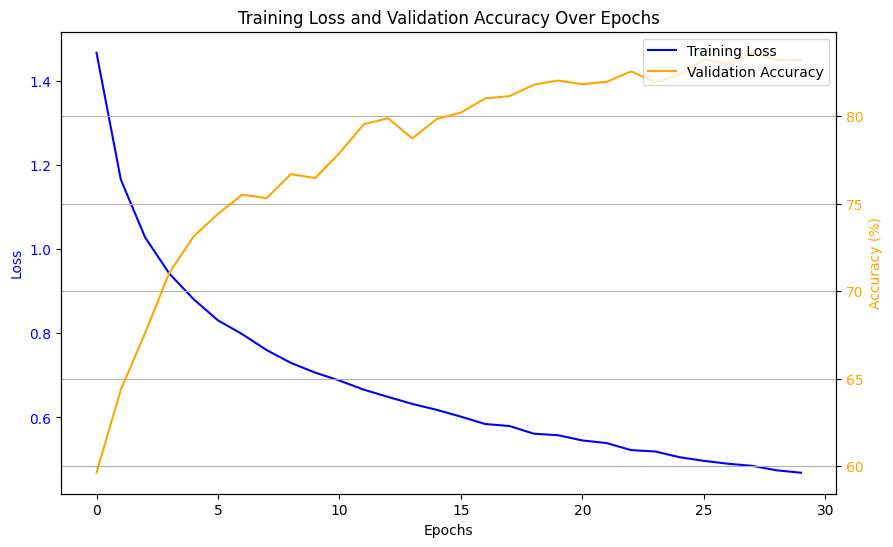

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Training Loss grafiği
ax1.plot(range(len(losses)), losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_title("Training Loss and Validation Accuracy Over Epochs")

# Validation Accuracy grafiği (sağ y ekseni)
ax2 = ax1.twinx()
ax2.plot(range(len(validation_accuracies)), validation_accuracies, label="Validation Accuracy", color="orange")
ax2.set_ylabel("Accuracy (%)", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

# Legend
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid()
plt.show()

In [ ]:
total_correct = 0
total_predictions = 0

# Loop over training dataset
for x_batch, y_batch in dataloader:
    logits = model(x_batch.to("cuda")) # Forward pass on the mini-batch
    loss = F.cross_entropy(logits.cpu(), y_batch) # Compute loss

    # Calculate predictions for the batch
    pred_labels = torch.max(logits, dim=1).indices

    # Update total correct predictions and total predictions
    total_correct += (y_batch == pred_labels.cpu()).sum().item()
    total_predictions += y_batch.size(0)

# Calculate overall accuracy
overall_accuracy = total_correct / total_predictions
print(f"Training Accuracy: {overall_accuracy}")

Training Accuracy: 0.85518


In [ ]:
total_correct = 0
total_predictions = 0

# Loop over testing dataset
for x_batch, y_batch in dataloader_test:
    logits = model(x_batch.to("cuda")) # Forward pass on the mini-batch
    loss = F.cross_entropy(logits.cpu(), y_batch) # Compute loss

    # Calculate predictions for the batch
    pred_labels = torch.max(logits, dim=1).indices

    # Update total correct predictions and total predictions
    total_correct += (y_batch == pred_labels.cpu()).sum().item()
    total_predictions += y_batch.size(0)

# Calculate overall accuracy
overall_accuracy = total_correct / total_predictions
print(f"Testting Accuracy: {overall_accuracy}")


Testting Accuracy: 0.832


## Detecting and Segmenting Raccoons 🦝


#### **Step 1**

In this first step, you will set up the environment. You need to import the necessary libraries for this project, such as autodistill-grounded-sam, supervision, ultralytics, roboflow, and PyTorch with torchvision. Make sure to install them using pip. This ensures that we have all the tools we need to work with GroundedSAM and YOLO for image analysis and model training. The code is already given. Run & proceed to the next step.

In [ ]:
!pip install autodistill-grounded-sam
!pip install supervision
!pip install ultralytics
!pip install roboflow
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.2 MB/s eta 0:00:00


#### **Step 2**

Now, import the specific components that you will use from the installed libraries. You will be utilizing GroundedSAM for object detection and segmentation, CaptionOntology for defining object categories, plotting tools from autodistill, and OpenCV for basic image operations. Importing these modules makes them readily available for use in your code. The code is already given. Run & proceed to the next step.

In [ ]:
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology
from autodistill.utils import plot
import cv2

#### **Step 3**

Before you can start processing images, you need to prepare the dataset. Upload the dataset to Google Colab (if you are using Colab). This code block will focus on extracting image data from the zip file named 'images.zip'. First, define the path to the zip file and the directory where images should be extracted. Then, use the zip file library to extract the contents of the zip file into the specified directory. Unzip your files.

In [ ]:
import gdown
import zipfile

# Use the ID from the Google Drive link
file_id = "1eg8j_bzCoBPdu7i6kLSwiuAjOswIQDQ6"  # Replace with the ID part of the link
download_url = f"https://drive.google.com/uc?id={file_id}"
output_file = "images.zip"

# Download the file
gdown.download(download_url, output_file, quiet=False)

# Extract the zip file
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall("dataset")  # Extract files into the 'dataset' folder

print("Dataset successfully downloaded and extracted.")

Downloading...
From: https://drive.google.com/uc?id=1eg8j_bzCoBPdu7i6kLSwiuAjOswIQDQ6
To: /content/images.zip
100%|██████████| 5.93M/5.93M [00:00<00:00, 142MB/s]

Dataset successfully downloaded and extracted.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Step 4**

Here, initialize the GroundedSAM model (name it as base_model) using a specific ontology. The ontology, defined using CaptionOntology, specifies the categories of objects you are interested in. In this case, you are only focusing on detecting and segmenting 'raccoons.' Creating this base model sets the foundation for object recognition in your images. You will use this model to label your dataset.
Your code will look like this, fill the stars:
```
base_model = GroundedSAM(
    ontology=CaptionOntology(
        {
            "*******": "*******"
        }
    )
)
```





In [ ]:
base_model = GroundedSAM(
    ontology=CaptionOntology(
        {
            "raccoon": "raccoon"
        }
    )
)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

#### **Step 5**

Now, test the GroundedSAM model on a single image. Choose a random image from the dataset by hand, load it, perform inference using the .predict() method of `base_model`, and then visualize the results.

Use the plot function which will help you to see the detected objects, their bounding boxes, and segmentation masks overlaid on the original image. This gives you a visual confirmation of the model's performance.

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


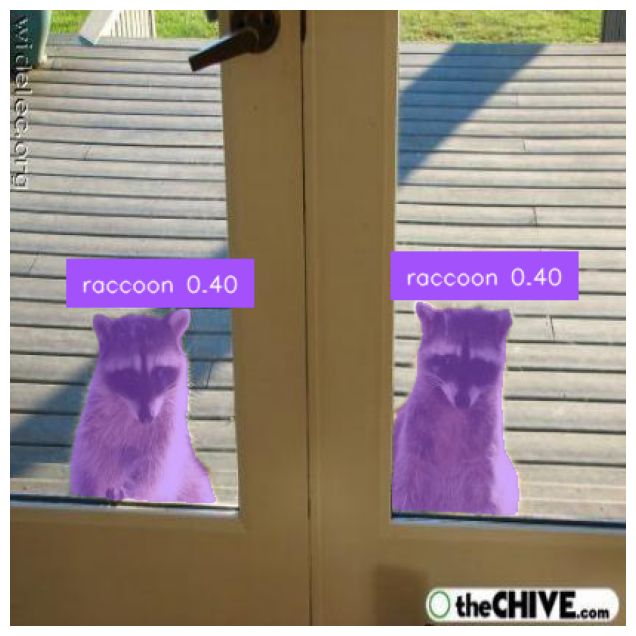

In [ ]:
# Load the image
image_path = "/content/dataset/images/rac (152).jpg"
image = cv2.imread(image_path)

# Perform inference
results = base_model.predict(image)

# Define the classes from the ontology
classes = ["raccoon"]

# Visualize results
plot(image, results, classes)

#### **Step 6**

To train a more specific model using YOLO, we need labeled data. Use the GroundedSAM model (named as `base_model` in previous steps) to label images. It will use the predefined ontology to identify and label 'raccoons' in the dataset. The labeled data will be crucial for fine-tuning the YOLO model in the next steps.

In [ ]:
base_model.label("/content/images_labeled/images/train", extension=".jpg")

Labeling images: 0it [00:00, ?it/s]

Labeled dataset created - ready for distillation.


In [ ]:
import os

# Directory containing the annotation .txt files
labels_dir = "/content/dataset/images_labeled/annotations"

# List all .txt files in the directory
txt_files = [f for f in os.listdir(labels_dir) if f.endswith(".txt")]

# Loop through each .txt file and display its contents
for txt_file in txt_files:
    print(f"Contents of {txt_file}:")
    with open(os.path.join(labels_dir, txt_file), "r") as file:
        print(file.read())

#### **Step 7**


Now over colab's UI, prepare a UI where you can view images with their labels. If the labeling is not successful, you will remove the image and its corresponding .txt labeling file. Iterate over the dataset and remove the unsuccessfully labeled ones. An example solution code for such UI is given below. Please note that it is natural to have a very different code as your solution as many things can vary (naming, design, paths, etc...).

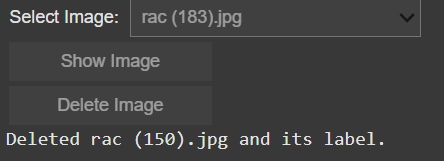


```
import os
import cv2
import shutil
import ipywidgets as widgets
from IPython.display import display, Image, clear_output
from google.colab.patches import cv2_imshow

# Define the paths
images_dir = "/content/images_labeled/train/images"
labels_dir = "/content/images_labeled/train/labels"

# Helper function to plot an image with detections
def plot_image_with_detections(image_path, base_model):
    image = cv2.imread(image_path)
    results = base_model.predict(image_path)
    plot(image=image, classes=base_model.ontology.classes(), detections=results)

# Function to refresh the list of images in the directory
def get_image_list():
    return [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

# Function to display image along with buttons to delete
def show_image_selection_ui(base_model):
    image_list = get_image_list()
    
    if not image_list:
        print("No images available.")
        return
    
    # Dropdown to select an image
    image_selector = widgets.Dropdown(
        options=image_list,
        description='Select Image:',
        disabled=False,
    )
    
    # Button to show the selected image
    show_button = widgets.Button(description="Show Image")
    
    # Button to delete the selected image
    delete_button = widgets.Button(description="Delete Image")
    
    output = widgets.Output()

    def show_image(change):
        with output:
            clear_output(wait=True)
            image_path = os.path.join(images_dir, image_selector.value)
            plot_image_with_detections(image_path, base_model)

    def delete_image(change):
        with output:
            clear_output(wait=True)
            # Delete the image and the corresponding label file
            image_path = os.path.join(images_dir, image_selector.value)
            label_path = os.path.join(labels_dir, os.path.splitext(image_selector.value)[0] + ".txt")
            
            if os.path.exists(image_path):
                os.remove(image_path)
            if os.path.exists(label_path):
                os.remove(label_path)
            
            # Update the dropdown options after deletion
            image_selector.options = get_image_list()
            print(f"Deleted {os.path.basename(image_path)} and its label.")
    
    show_button.on_click(show_image)
    delete_button.on_click(delete_image)
    
    # Display UI components
    display(image_selector, show_button, delete_button, output)

# Call this function to start the UI
show_image_selection_ui(base_model)
```



In [ ]:
import os
import cv2
import shutil
import ipywidgets as widgets
from IPython.display import display, Image, clear_output
from google.colab.patches import cv2_imshow

# Define the paths
images_dir = "/content/dataset/images_labeled/train/images"
labels_dir = "/content/dataset/images_labeled/train/labels"

# Helper function to plot an image with detections
def plot_image_with_detections(image_path, base_model):
    image = cv2.imread(image_path)
    results = base_model.predict(image_path)
    plot(image=image, classes=base_model.ontology.classes(), detections=results)

# Function to refresh the list of images in the directory
def get_image_list():
    return [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

# Function to display image along with buttons to delete
def show_image_selection_ui(base_model):
    image_list = get_image_list()

    if not image_list:
        print("No images available.")
        return

    # Dropdown to select an image
    image_selector = widgets.Dropdown(
        options=image_list,
        description='Select Image:',
        disabled=False,
    )

    # Button to show the selected image
    show_button = widgets.Button(description="Show Image")

    # Button to delete the selected image
    delete_button = widgets.Button(description="Delete Image")

    output = widgets.Output()

    def show_image(change):
        with output:
            clear_output(wait=True)
            image_path = os.path.join(images_dir, image_selector.value)
            plot_image_with_detections(image_path, base_model)

    def delete_image(change):
        with output:
            clear_output(wait=True)
            # Delete the image and the corresponding label file
            image_path = os.path.join(images_dir, image_selector.value)
            label_path = os.path.join(labels_dir, os.path.splitext(image_selector.value)[0] + ".txt")

            if os.path.exists(image_path):
                os.remove(image_path)
            if os.path.exists(label_path):
                os.remove(label_path)

            # Update the dropdown options after deletion
            image_selector.options = get_image_list()
            print(f"Deleted {os.path.basename(image_path)} and its label.")

    show_button.on_click(show_image)
    delete_button.on_click(delete_image)

    # Display UI components
    display(image_selector, show_button, delete_button, output)

# Call this function to start the UI
show_image_selection_ui(base_model)

Dropdown(description='Select Image:', options=('rac (139).jpg', 'rac (192).jpg', 'rac (13).jpg', 'rac (29).jpg…

Button(description='Show Image', style=ButtonStyle())

Button(description='Delete Image', style=ButtonStyle())

Output()

In [ ]:
# Define source and destination paths
source_path = "/content/drive/My Drive/dataset"  # Path to the dataset in Google Drive
destination_path = "/content/dataset"  # Path where the dataset will be moved in Colab

# Check if the source directory exists
if os.path.exists(source_path):  # Verify that the source directory exists
    # Move the directory to Colab
    shutil.move(source_path, destination_path)  # Move the dataset to the destination path
    print(f"Dataset successfully moved to {destination_path}")  # Confirm successful move
else:
    print("Source directory does not exist.")  # Alert if the source directory is missing

Dataset successfully moved to /content/dataset


#### **Step 8**

Now leverage the power of YOLO for more robust object detection. Start by importing the YOLO from the ultralytics library. Then, load a pre-trained YOLO11n model. Name it `model_detect`.

Use:
`model_detect = YOLO("yolo11n.pt")`

Next, use the .train() method to fine-tune this model on the labeled data generated earlier. This process will involve feeding the model our labeled images and allowing it to learn and adjust its parameters for better performance. Pass the path to the .yaml file (ex.  `data="/content/images_labeled/data.yaml"`) inside the train function. Remember to specify training parameters. Set  `imgsz=416` and `name="yolo_detection"`.




In [ ]:
from ultralytics import YOLO

# Load the pre-trained YOLO11n model
model_detect = YOLO("yolo11n.pt")

print("YOLO11n model successfully loaded as 'model_detect'.")

YOLO11n model successfully loaded as 'model_detect'.


In [ ]:
# Fine-tune the YOLO model
model_detect.train(
    data="/content/drive/MyDrive/dataset/images_labeled/data.yaml",  # Path to the dataset yaml file
    imgsz=416,                                                      # Input image size
    epochs=50,                                                      # Number of training epochs
    batch=16,                                                       # Batch size
    name="yolo_detection",                                          # Name for the training run
    device=0                                                        # Use GPU if available
)

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/dataset/images_labeled/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolo_detection6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fa

train: Scanning /content/drive/MyDrive/dataset/images_labeled/train/labels.cache... 107 images, 18 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


train: Scanning /content/drive/MyDrive/dataset/images_labeled/train/labels.cache... 107 images, 18 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:00<?, ?it/s]
val: Scanning /content/drive/MyDrive/dataset/images_labeled/valid/labels.cache... 40 images, 14 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo_detection6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/yolo_detection6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       4.5G      1.145      1.148      1.289         34        416: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.97it/s]

                   all         40         32      0.607      0.675      0.567      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.45G       1.01      1.027       1.27         29        416: 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]

                   all         40         32      0.778      0.547      0.599      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.46G     0.8883     0.9454      1.203         24        416: 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]

                   all         40         32      0.758      0.531      0.525      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.45G      0.827      0.839      1.169         31        416: 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]

                   all         40         32      0.684       0.61       0.55      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.46G     0.8212     0.8689      1.154         32        416: 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]

                   all         40         32      0.624      0.594       0.53      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.45G     0.8299     0.9628      1.169         31        416: 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.92it/s]


                   all         40         32      0.562      0.562      0.463      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.46G     0.8834      0.885      1.192         31        416: 100%|██████████| 7/7 [00:00<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]


                   all         40         32      0.492      0.605      0.514      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.46G     0.9047     0.9941      1.206         26        416: 100%|██████████| 7/7 [00:00<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


                   all         40         32      0.685      0.475      0.549      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.46G     0.8553     0.9158      1.199         41        416: 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.07it/s]

                   all         40         32      0.345      0.562      0.418      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.45G     0.8881     0.9468      1.238         28        416: 100%|██████████| 7/7 [00:00<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]

                   all         40         32      0.431      0.531      0.429      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.46G     0.9758      1.015      1.241         32        416: 100%|██████████| 7/7 [00:00<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.62it/s]


                   all         40         32      0.619      0.438      0.457      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.46G      0.968     0.9144       1.23         30        416: 100%|██████████| 7/7 [00:00<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


                   all         40         32      0.629        0.5       0.52      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.46G     0.9703     0.9613      1.208         22        416: 100%|██████████| 7/7 [00:00<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]


                   all         40         32      0.723      0.625      0.574      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.46G     0.9832      1.085       1.24         28        416: 100%|██████████| 7/7 [00:00<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.91it/s]


                   all         40         32      0.535      0.625      0.452      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.45G      0.957      1.002      1.232         29        416: 100%|██████████| 7/7 [00:00<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         40         32      0.703        0.5      0.458      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.46G      1.029      1.071      1.272         31        416: 100%|██████████| 7/7 [00:00<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]

                   all         40         32      0.612      0.625      0.526      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.46G     0.9815      1.022      1.263         31        416: 100%|██████████| 7/7 [00:00<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.76it/s]

                   all         40         32      0.717        0.5      0.541      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.46G     0.9949      1.025      1.233         23        416: 100%|██████████| 7/7 [00:00<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.11it/s]

                   all         40         32      0.701      0.531      0.495      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.45G     0.9756     0.9992      1.253         25        416: 100%|██████████| 7/7 [00:00<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]

                   all         40         32      0.736      0.469      0.447       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.46G     0.9475      1.005      1.255         30        416: 100%|██████████| 7/7 [00:00<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]

                   all         40         32       0.63      0.469      0.462      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.46G     0.9344     0.9828      1.241         30        416: 100%|██████████| 7/7 [00:00<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.93it/s]

                   all         40         32      0.693      0.562      0.541      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.46G     0.8812      0.977      1.214         24        416: 100%|██████████| 7/7 [00:00<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


                   all         40         32       0.75      0.531      0.571        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.45G     0.9196      1.003      1.218         22        416: 100%|██████████| 7/7 [00:00<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.94it/s]

                   all         40         32      0.639      0.469      0.507      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.46G     0.9885      1.022      1.264         21        416: 100%|██████████| 7/7 [00:00<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.40it/s]

                   all         40         32      0.567      0.531       0.52      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.46G     0.9043     0.9511      1.216         27        416: 100%|██████████| 7/7 [00:00<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]

                   all         40         32      0.627      0.562      0.545      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.46G     0.9267     0.9086      1.232         29        416: 100%|██████████| 7/7 [00:00<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


                   all         40         32       0.59      0.688      0.621       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.45G     0.8648     0.8692       1.19         30        416: 100%|██████████| 7/7 [00:00<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


                   all         40         32      0.706      0.625      0.637      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.46G     0.8984     0.8957      1.216         25        416: 100%|██████████| 7/7 [00:00<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.32it/s]

                   all         40         32      0.643      0.656      0.561      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.46G     0.8827     0.8746      1.205         23        416: 100%|██████████| 7/7 [00:00<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]

                   all         40         32      0.587      0.594      0.491      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.46G     0.9054      0.928      1.193         23        416: 100%|██████████| 7/7 [00:00<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.33it/s]

                   all         40         32      0.608      0.531      0.497      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.45G     0.8624     0.8534       1.16         24        416: 100%|██████████| 7/7 [00:00<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


                   all         40         32      0.602      0.531      0.528      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.45G     0.9083     0.9045      1.205         19        416: 100%|██████████| 7/7 [00:00<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.28it/s]


                   all         40         32      0.582      0.719      0.614       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.46G     0.8345     0.8538      1.178         30        416: 100%|██████████| 7/7 [00:00<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.83it/s]

                   all         40         32       0.65      0.719      0.631      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.46G     0.7732     0.7933      1.145         31        416: 100%|██████████| 7/7 [00:00<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.51it/s]

                   all         40         32      0.729      0.688      0.681      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.45G     0.7179     0.7666      1.122         30        416: 100%|██████████| 7/7 [00:00<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]

                   all         40         32      0.676      0.688      0.643      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.46G     0.8402     0.8584      1.225         28        416: 100%|██████████| 7/7 [00:00<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.66it/s]

                   all         40         32       0.67      0.719      0.641        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.46G     0.7549     0.7666      1.138         31        416: 100%|██████████| 7/7 [00:00<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]

                   all         40         32      0.746      0.688       0.67      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.46G     0.8329     0.8152       1.17         28        416: 100%|██████████| 7/7 [00:00<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.91it/s]

                   all         40         32      0.693      0.719      0.654        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.45G     0.7557     0.7889      1.134         25        416: 100%|██████████| 7/7 [00:00<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]

                   all         40         32      0.817      0.559      0.586      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.46G     0.7166     0.7168      1.101         24        416: 100%|██████████| 7/7 [00:00<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.24it/s]

                   all         40         32      0.818      0.625      0.646      0.418


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.45G     0.4828     0.9395     0.9964         11        416: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.93it/s]

                   all         40         32      0.825      0.594      0.665      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.45G       0.47      0.771     0.9964          9        416: 100%|██████████| 7/7 [00:00<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


                   all         40         32      0.637      0.656      0.623      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.44G     0.4245     0.6318     0.9439          9        416: 100%|██████████| 7/7 [00:00<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.93it/s]


                   all         40         32      0.584      0.562      0.537      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.45G     0.4627     0.6138     0.9694         12        416: 100%|██████████| 7/7 [00:00<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]

                   all         40         32      0.579      0.562      0.531       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.45G     0.5142     0.6554       1.01         10        416: 100%|██████████| 7/7 [00:00<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]


                   all         40         32      0.572      0.562      0.551      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.46G     0.4116     0.5488     0.9858         13        416: 100%|██████████| 7/7 [00:00<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]

                   all         40         32      0.629      0.594      0.548      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.45G     0.4428      0.581     0.9368          7        416: 100%|██████████| 7/7 [00:00<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.84it/s]

                   all         40         32      0.781      0.562      0.629      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.45G     0.4196     0.5629     0.9564          9        416: 100%|██████████| 7/7 [00:00<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]

                   all         40         32      0.686      0.531      0.642      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.45G     0.4034     0.5614     0.9643         12        416: 100%|██████████| 7/7 [00:00<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]

                   all         40         32      0.676      0.588      0.643      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.45G     0.4001     0.5237     0.9465         10        416: 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.16it/s]


                   all         40         32      0.648      0.577      0.642      0.428

50 epochs completed in 0.037 hours.
Optimizer stripped from runs/detect/yolo_detection6/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/yolo_detection6/weights/best.pt, 5.4MB

Validating runs/detect/yolo_detection6/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 24.12it/s]

                   all         40         32      0.648      0.577      0.642      0.428


Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/yolo_detection6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dae355928c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

#### **Step 9**

Now, let's see the YOLO model in action on a new image! Load a test image, choose it by hand from the validation dataset and use the trained model to make prediction on it. The result will contain information about the detected object, including their bounding boxes and confidence scores.

Use the show method to display the results visually – this will overlay the detected objects on the test image, giving you a clear view of the model's detection capabilities.


image 1/1 /content/drive/MyDrive/dataset/images_labeled/valid/images/rac (12).jpg: 416x416 1 raccoon, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict27


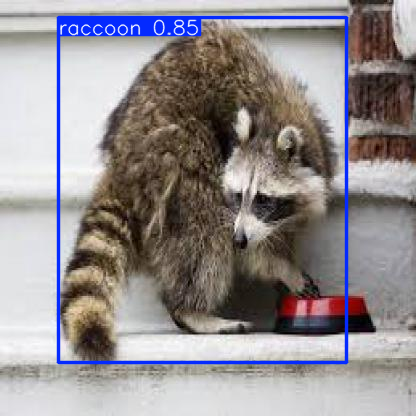

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Load the trained model
model = YOLO("/content/runs/detect/yolo_detection6/weights/best.pt")  # Replace with the path to your trained model

# Path to a new test image (choose a specific image from the validation dataset)
test_image_path = "/content/drive/MyDrive/dataset/images_labeled/valid/images/rac (12).jpg"  # New test image

# Perform prediction
results = model.predict(source=test_image_path, save=True, conf=0.25)

# Show the image with detected objects
results[0].plot(show=True)
Output_image_path = f"runs/detect/predict/{test_image_path.split('/')[-1]}"  # Output image path
image_with_detections = cv2.imread(output_image_path)


#### **Step 10**

For the detection model, output the "results.png" generated in /runs folder.

In [ ]:
# Folder containing the training results
source_path = "runs/detect/yolo_detection6/results.png"  # Path to the results file (adjust based on your YOLO run folder)
destination_path = "/content/drive/MyDrive/results.png"  # Target location in Google Drive

# Copy the file to the target location
if os.path.exists(source_path):  # Check if the results file exists
    shutil.copy(source_path, destination_path)  # Copy the file to the destination path
    print(f"results.png has been copied to {destination_path}")  # Success message
else:
    print("results.png not found. Make sure the training has completed and the file exists.")  # Error message

results.png has been copied to /content/drive/MyDrive/results.png


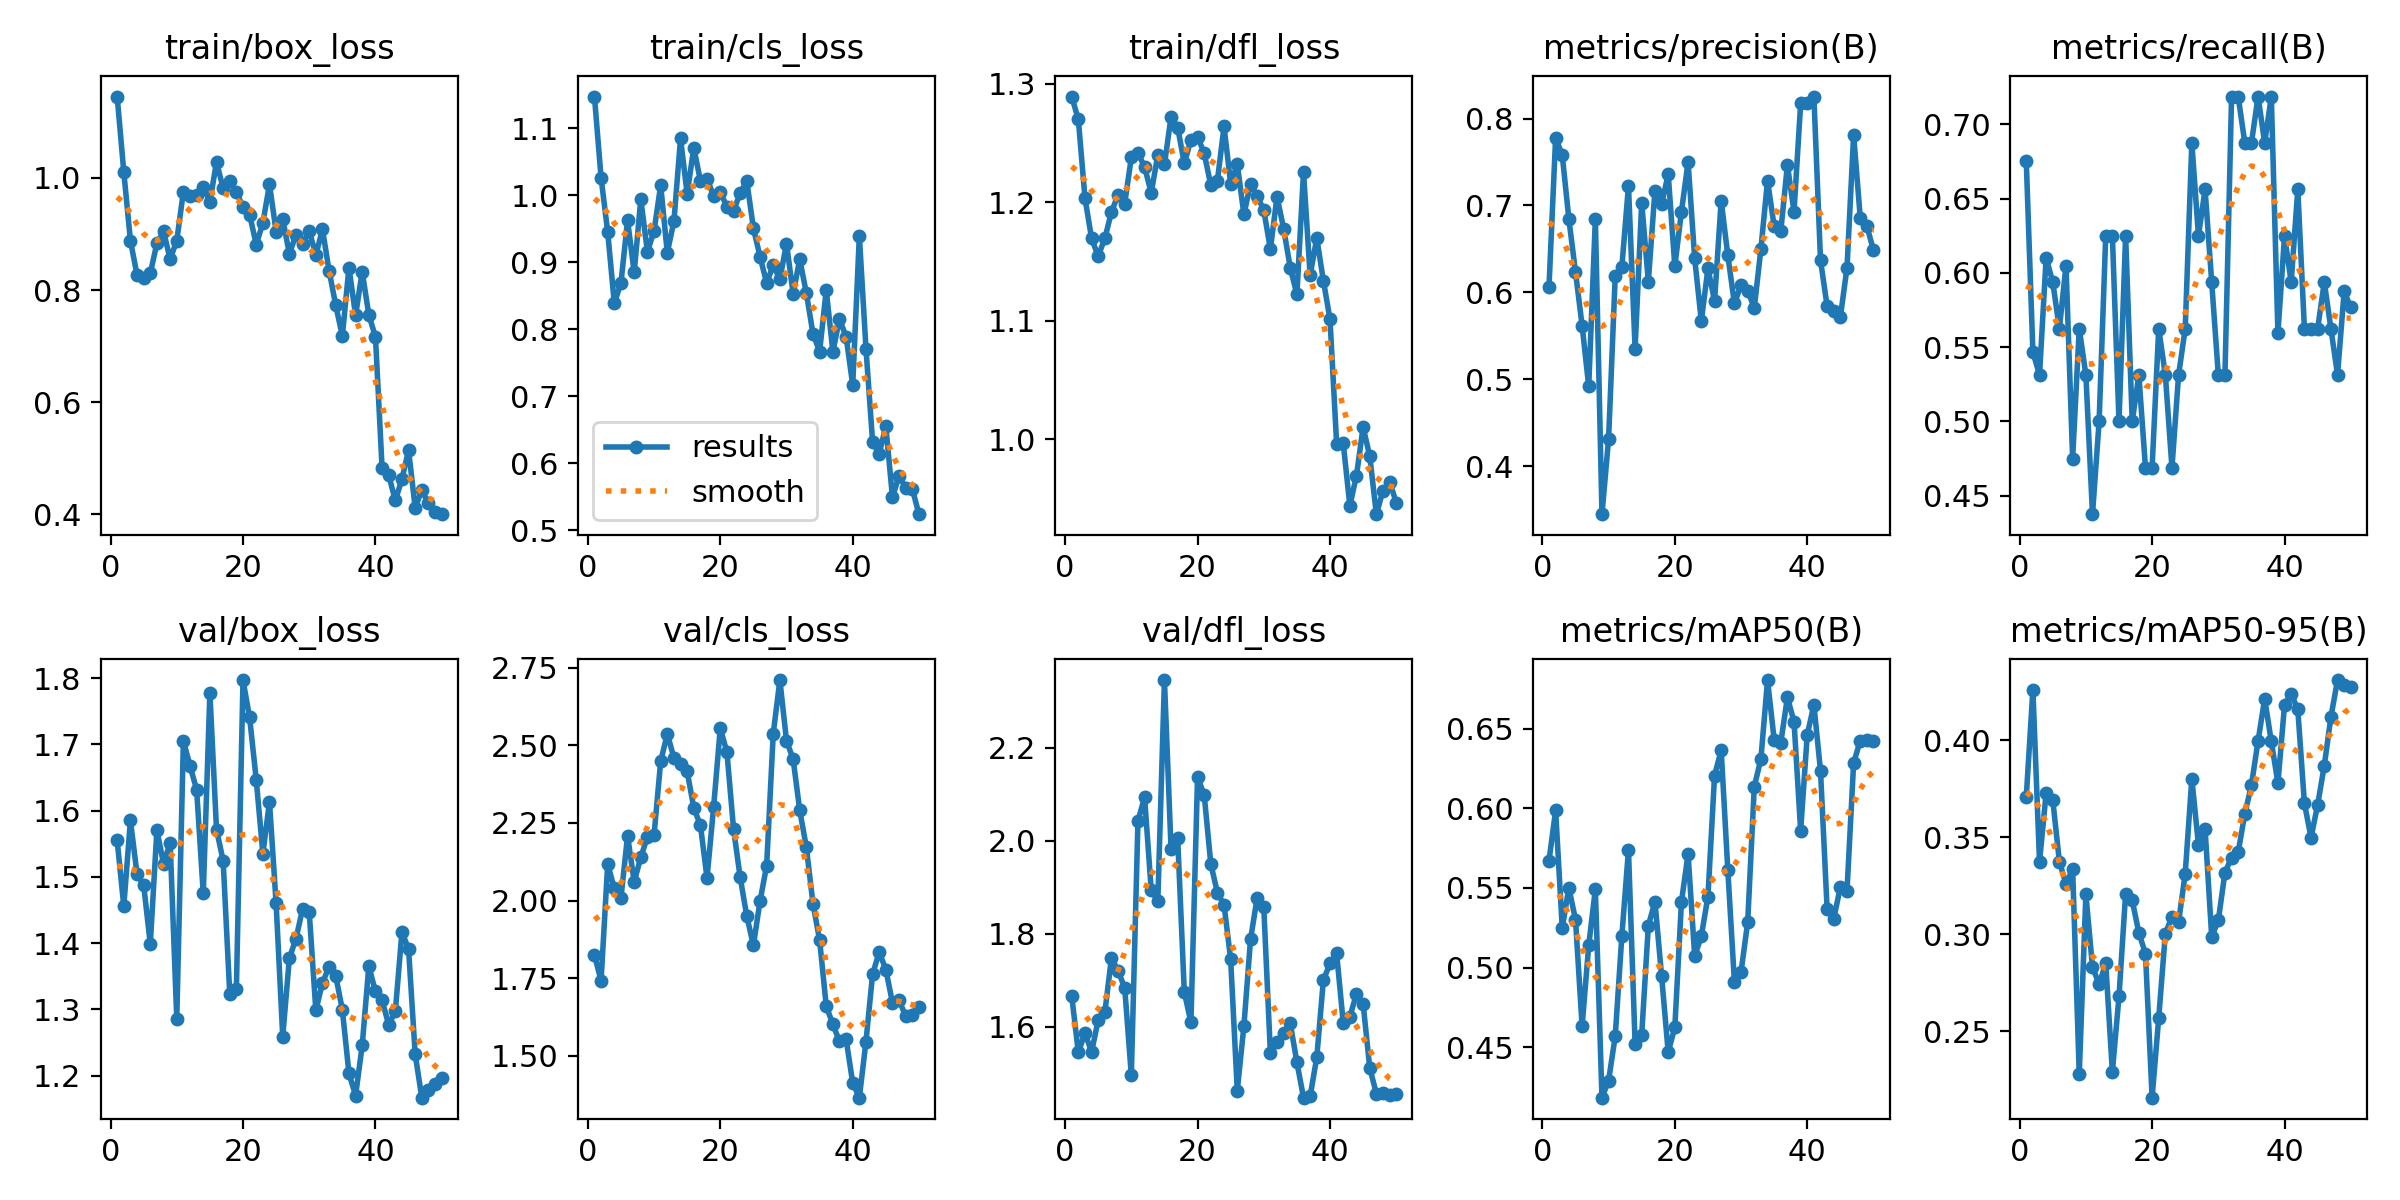

In [ ]:
from IPython.display import Image, display

# Display the visualization file
display(Image(filename=destination_path))  # Show the results file from the destination path

#### **Step 11**

Finally, to make your trained YOLO model usable in other environments or applications, you need to export it to a suitable format. The export method allows you to save the model in various formats like ONNX, Torchscript, or CoreML, depending on your needs.

In this exercise you will export your model in "onnx" format for future use. This ensures that your trained model is portable and can be integrated into different systems.

In [ ]:
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO("/content/runs/detect/yolo_detection6/weights/best.pt")  # Path to your trained model

# Export the model to ONNX format
model.export(format="onnx", dynamic=True, simplify=True)

print("Model successfully exported to ONNX format.")

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/runs/detect/yolo_detection6/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 5, 3549) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 222.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 250.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 229.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 187.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 226.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 16.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or re

#### **Step 12**

Now do the last steps again with the segmentation model.
Start with the code below. Again, set `imgsz=416` and `name="yolo_segmentation"`.

Use:
`model_segment = YOLO("yolo11n-seg.pt")`

In [ ]:
# Load the segmentation model
model_segment = YOLO("yolo11n-seg.pt")  # Use the YOLO segmentation model

# Train the model with segmentation data
model_segment.train(
    data="/content/drive/MyDrive/dataset/images_labeled/data.yaml",  # Path to the dataset YAML
    imgsz=416,                                                      # Image size
    epochs=50,                                                      # Number of epochs
    batch=16,                                                       # Batch size
    name="yolo_segmentation",                                       # Run name
    device=0                                                        # Use GPU if available
)

100%|██████████| 5.90M/5.90M [00:00<00:00, 71.2MB/s]


Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/content/drive/MyDrive/dataset/images_labeled/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolo_segmentation, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_

train: Scanning /content/drive/MyDrive/dataset/images_labeled/train/labels.cache... 107 images, 18 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/dataset/images_labeled/valid/labels/predict10... 40 images, 15 backgrounds, 0 corrupt: 100%|██████████| 41/41 [00:00<00:00, 89.06it/s]


val: New cache created: /content/drive/MyDrive/dataset/images_labeled/valid/labels/predict10.cache
Plotting labels to runs/segment/yolo_segmentation/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/segment/yolo_segmentation
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.77G      1.205      4.297      2.607      1.478         34        416: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         41         32     0.0022      0.844      0.149     0.0859    0.00203      0.781      0.167     0.0787



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.69G       1.06      3.275      2.493      1.372         29        416: 100%|██████████| 7/7 [00:01<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         41         32    0.00252      0.969      0.272      0.168    0.00211      0.812      0.176     0.0634



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50       4.7G       1.02      2.177      2.271      1.324         24        416: 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         41         32    0.00244      0.938      0.431      0.328    0.00244      0.938      0.419      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.67G     0.9807      2.165      2.031      1.285         31        416: 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         41         32    0.00228      0.875      0.441      0.322     0.0022      0.844      0.434      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.69G     0.9919      1.777      1.861      1.302         32        416: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         41         32      0.659      0.344      0.422       0.21      0.659      0.344      0.399      0.243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.66G      1.083      1.914      1.747      1.361         31        416: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         41         32      0.378      0.531       0.29      0.171      0.315      0.438      0.245      0.145



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50       4.7G      1.157      2.133      1.584       1.38         31        416: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         41         32      0.369      0.312      0.357       0.16      0.427      0.312      0.329      0.159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.69G      1.235      2.144      1.591      1.459         26        416: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

                   all         41         32       0.32      0.406      0.274      0.135      0.351      0.406      0.302      0.142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.67G      1.137      1.913      1.434      1.389         41        416: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         41         32      0.376      0.375      0.289      0.133      0.473      0.406      0.335      0.171



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50       4.7G      1.126       1.95      1.416      1.384         28        416: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         41         32      0.186       0.25      0.112     0.0547      0.292      0.375      0.215     0.0743



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.71G      1.102      1.907       1.36      1.374         32        416: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         41         32      0.203      0.278      0.102     0.0269      0.132      0.219     0.0687     0.0194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.69G      1.116      1.907      1.284      1.329         30        416: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

                   all         41         32     0.0893      0.188     0.0598     0.0174     0.0689      0.344     0.0438     0.0158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50       4.7G      1.093      1.804      1.311      1.308         22        416: 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         41         32     0.0649       0.25     0.0556     0.0198      0.061       0.25     0.0348     0.0152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.71G      1.147      1.721      1.403      1.369         28        416: 100%|██████████| 7/7 [00:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         41         32      0.302      0.438       0.26      0.116      0.302      0.438      0.245      0.125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50       4.7G      1.154      1.864      1.274      1.344         29        416: 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         41         32      0.324      0.469      0.211     0.0749      0.368      0.531      0.283      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.72G      1.174      1.902      1.343      1.358         31        416: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         41         32      0.508        0.5       0.43      0.192      0.541      0.531      0.453      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50       4.7G      1.104      1.941      1.237      1.343         31        416: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         41         32      0.544      0.562      0.497      0.272      0.544      0.562      0.494      0.282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50       4.7G       1.11      1.888      1.257       1.29         23        416: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         41         32      0.526      0.438      0.373       0.22      0.526      0.438      0.369      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.69G      1.028      1.923      1.168      1.299         25        416: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         41         32      0.421      0.531      0.358      0.207      0.368      0.469      0.305      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.68G      1.011      1.859      1.162      1.259         30        416: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         41         32      0.516        0.5      0.387      0.223      0.511      0.458      0.359      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.71G      1.053      1.828      1.176      1.296         30        416: 100%|██████████| 7/7 [00:01<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         41         32      0.486      0.443      0.429      0.269      0.535      0.406      0.373      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.69G     0.9213      1.844       1.08      1.233         24        416: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         41         32      0.444      0.548      0.455      0.327      0.443      0.406      0.403      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.68G      1.079      1.718      1.159      1.329         22        416: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.07it/s]

                   all         41         32      0.507      0.625      0.508      0.305      0.507      0.625       0.48      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.69G       1.06      1.734      1.179      1.313         21        416: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         41         32      0.481      0.656      0.511      0.332      0.465      0.625      0.484      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.69G      1.029      1.564      1.082      1.263         27        416: 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]

                   all         41         32      0.452      0.625      0.485      0.329      0.452      0.625      0.462      0.282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.69G     0.9952      1.588      1.085      1.256         29        416: 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         41         32      0.461      0.625        0.5       0.33      0.461      0.625      0.474      0.294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50       4.7G      0.899      1.558      1.005      1.211         30        416: 100%|██████████| 7/7 [00:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

                   all         41         32      0.531      0.461      0.462      0.307      0.531      0.461      0.452      0.281



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.68G     0.9606      1.496      1.061      1.244         25        416: 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

                   all         41         32      0.631        0.5      0.505      0.365      0.631        0.5      0.489      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50       4.7G     0.9697      1.416      1.045      1.265         23        416: 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         41         32      0.624      0.562      0.546      0.351      0.624      0.562      0.528       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.69G      1.006      1.498      1.038      1.291         23        416: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         41         32      0.614      0.594      0.542      0.352      0.614      0.594      0.544      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.68G     0.9419       1.52      1.008      1.212         24        416: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         41         32      0.666      0.438      0.513      0.369      0.495      0.613      0.526      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50       4.7G       1.01      1.414      1.047      1.238         19        416: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         41         32      0.778      0.437      0.548      0.394      0.778      0.437      0.538      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.69G     0.9197       1.36     0.9837       1.22         30        416: 100%|██████████| 7/7 [00:01<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         41         32      0.716      0.438      0.542      0.392      0.716      0.438      0.527      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50       4.7G     0.8243      1.289     0.9145      1.168         31        416: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]

                   all         41         32      0.555      0.625       0.51      0.371      0.582      0.656      0.527      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.67G     0.8486      1.159      0.863      1.186         30        416: 100%|██████████| 7/7 [00:01<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.18it/s]

                   all         41         32      0.581      0.656      0.505      0.356      0.581      0.656      0.503      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.68G     0.9617      1.481      1.006      1.278         28        416: 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.17it/s]

                   all         41         32      0.674      0.582      0.525      0.394      0.674      0.582      0.514      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50       4.7G     0.8196      1.394     0.8746      1.173         31        416: 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

                   all         41         32      0.652      0.585      0.526      0.401      0.652      0.585      0.516      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.68G     0.8838      1.136     0.9846      1.217         28        416: 100%|██████████| 7/7 [00:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         41         32       0.62      0.625      0.554      0.401      0.587      0.594      0.522      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.69G     0.8251      1.296     0.8956      1.155         25        416: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

                   all         41         32      0.583      0.625      0.544      0.396      0.583      0.625      0.537      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50       4.7G       0.78      1.182     0.8466      1.118         24        416: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         41         32      0.704      0.594      0.575      0.412      0.704      0.594      0.572      0.432


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.69G     0.5141     0.9094      1.094      1.043         11        416: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         41         32      0.621      0.625      0.581      0.413      0.621      0.625      0.565      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.69G     0.5409     0.8739      0.922      1.068          9        416: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         41         32      0.612      0.625      0.534      0.364       0.58      0.594        0.5      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.68G     0.4797     0.8074     0.8156     0.9999          9        416: 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         41         32      0.544      0.625      0.446      0.299      0.517      0.594      0.399      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.69G     0.5049     0.7815     0.8259     0.9948         12        416: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         41         32      0.537      0.625      0.459      0.304      0.509      0.594      0.406      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.69G       0.49     0.7697      0.819     0.9797         10        416: 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

                   all         41         32      0.553      0.625      0.455      0.353      0.526      0.594      0.443      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.69G     0.4552     0.7658     0.7064      1.005         13        416: 100%|██████████| 7/7 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         41         32       0.61      0.625      0.556      0.429      0.577      0.594      0.522      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.66G     0.4071     0.7507     0.7118     0.9223          7        416: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         41         32      0.727      0.594      0.563      0.431      0.727      0.594      0.563      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.69G     0.4439     0.7991     0.7291     0.9674          9        416: 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         41         32      0.667      0.625       0.58      0.426      0.704      0.562      0.554      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.68G     0.4456      0.774     0.6923     0.9988         12        416: 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         41         32      0.691      0.625       0.58      0.418      0.678      0.592      0.555      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.69G     0.4063     0.7133     0.6335      0.958         10        416: 100%|██████████| 7/7 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         41         32      0.656      0.597      0.557      0.418      0.656      0.597      0.559      0.429



50 epochs completed in 0.034 hours.
Optimizer stripped from runs/segment/yolo_segmentation/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/yolo_segmentation/weights/best.pt, 6.0MB

Validating runs/segment/yolo_segmentation/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


                   all         41         32      0.726      0.594      0.562       0.43      0.726      0.594      0.563      0.436
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/segment/yolo_segmentation


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dae56838250>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

#### **Step 13**

Again, use the show method to display the results visually for the same image you choose in step 9 – this will overlay the detected objects with their segmentations on the test image, giving you a clear view of the model's segmentation capabilities.


image 1/1 /content/drive/MyDrive/dataset/images_labeled/valid/images/rac (12).jpg: 416x416 1 raccoon, 12.9ms
Speed: 1.0ms preprocess, 12.9ms inference, 3.7ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/segment/predict5


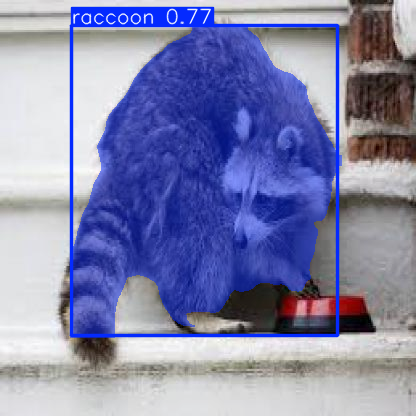

In [ ]:
# Load the trained segmentation model
model_segment = YOLO("runs/segment/yolo_segmentation/weights/best.pt")  # Replace with your trained model path

# Path to the test image (same as step 9)
test_image_path = "/content/drive/MyDrive/dataset/images_labeled/valid/images/rac (12).jpg"  # Replace with your test image

# Perform segmentation
results = model_segment.predict(source=test_image_path, conf=0.25, save=True)

# Display the segmentation results visually
results[0].plot(show=True)
output_image_path = f"runs/detect/predict/{test_image_path.split('/')[-1]}"  # Output image path
image_with_detections = cv2.imread(output_image_path)

#### **Step 14**

For the segmentation model, output the "results.png" generated in the /runs folder.

In [ ]:
import shutil
import os

# Path to the folder containing training or prediction results
source_path = "runs/segment/yolo_segmentation/results.png"  # Path to the segmentation results file
destination_path = "/content/drive/MyDrive/results_segmentation.png"  # Destination folder in Google Drive

# Check if the file exists and copy it to the target location
if os.path.exists(source_path):  # Verify if the source file exists
    shutil.copy(source_path, destination_path)  # Copy the file to the destination
    print(f"results.png has been copied to {destination_path}")  # Success message
else:
    print("results.png not found. Make sure the training or prediction has completed and the file exists.")  # Error message

results.png has been copied to /content/drive/MyDrive/results_segmentation.png


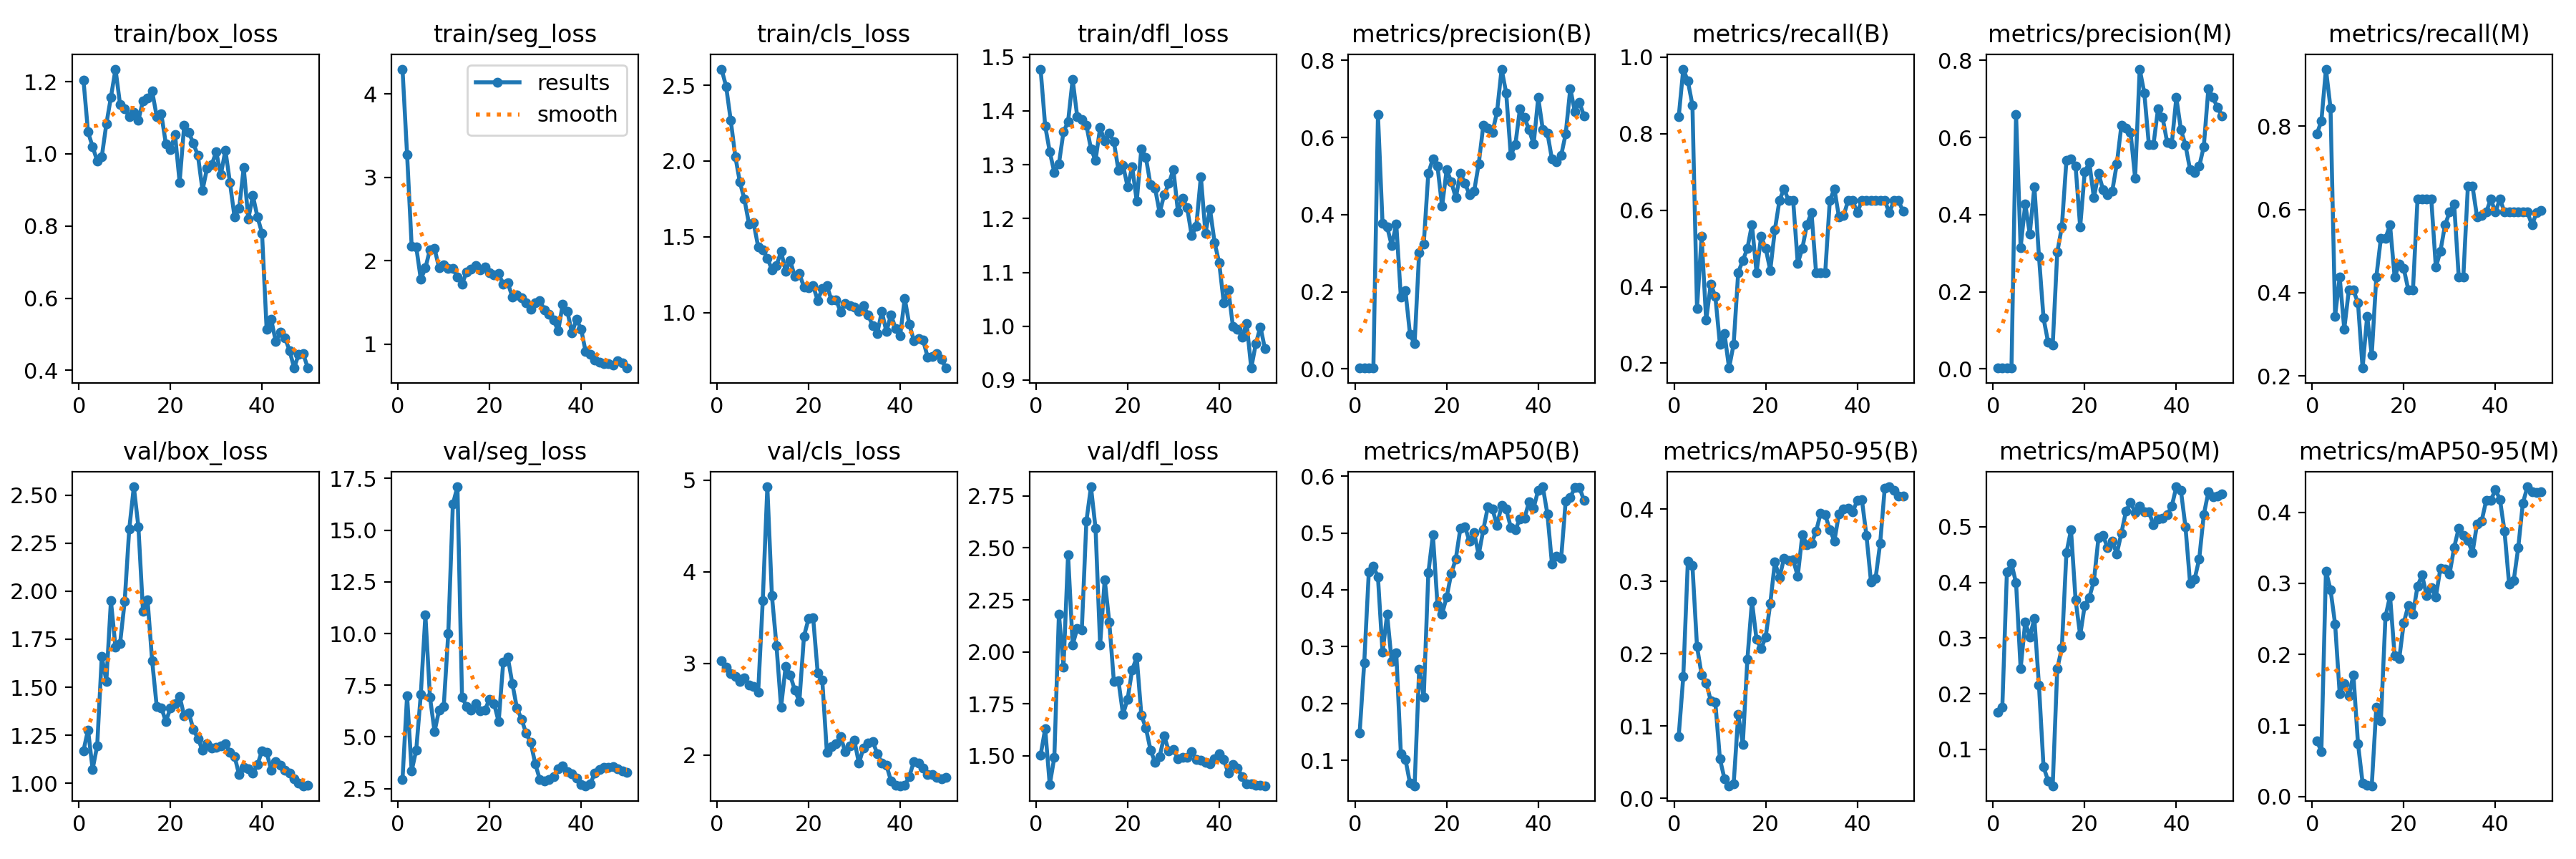

In [ ]:
from IPython.display import Image, display
display(Image(filename="/content/drive/MyDrive/results_segmentation.png"))

#### **Step 15**

Export your segmentation model in "onnx" format.

In [ ]:
from ultralytics import YOLO

# Load the trained segmentation model
model_segment = YOLO("runs/segment/yolo_segmentation/weights/best.pt")  # Replace with your trained model path

# Export the model to ONNX format
model_segment.export(format="onnx", dynamic=True, simplify=True)

print("Segmentation model successfully exported to ONNX format.")

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n-seg summary (fused): 265 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs

PyTorch: starting from 'runs/segment/yolo_segmentation/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) ((1, 37, 3549), (1, 32, 104, 104)) (5.7 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.42...
ONNX: export success ✅ 27.3s, saved as 'runs/segment/yolo_segmentation/weights/best.onnx' (11.0 MB)

Export complete (27.9s)
Results saved to /content/runs/segment/yolo_segmentation/weights
Predict:         yolo predict task=segment model=runs/segment/yolo_segmentation/weights/best.onnx imgsz=416  
Validate:        yolo val task=segment model=runs/segment/yolo_segmentation/weights/best.onnx imgsz=416 data=/content/drive/MyDrive/dataset/images_labeled/data.yaml  
Visualize:       https://netron.app
Segmentation model successfully exported to ONNX format.


In [ ]:
import os

onnx_path = "runs/segment/yolo_segmentation/weights/best.onnx"  # Replace with the expected ONNX file path

if os.path.exists(onnx_path):
    print(f"ONNX model successfully exported at: {onnx_path}")
else:
    print("Error: ONNX model export failed.")

ONNX model successfully exported at: runs/segment/yolo_segmentation/weights/best.onnx


Congratulations! 🎉

Now you have successfully fine-tuned your detection and segmentation models. They are ready to use.